In [1]:
import xarray as xr
import os
import socket
import numpy as np
import matplotlib.pyplot as plt
import subprocess

host = socket.gethostname()
if host == 'mpc2959.psi.ch' or host == 'mpc2053.psi.ch':
    gitpath = '/mpc/homes/fische_r/lib/co2ely-tomcat'
    toppath = '/mpc/homes/fische_r/NAS/DASCOELY'
    toppathSSD = '/mnt/SSD/fische_r/COELY'
    temppath = '/mnt/SSD/fische_r/tmp'
    training_path = '/mpc/homes/fische_r/NAS/DASCOELY/processing/05_water_GDL_ML/'
    num_GPU = 5

elif host == 'mpc2053.psi.ch':
    gitpath = '/mpc/homes/fische_r/lib/co2ely-tomcat'
    toppath = '/mpc/homes/fische_r/NAS/DASCOELY'
    toppathSSD = '/mpc/homes/fische_r/NAS/DASCOELY/processing'
    temppath = '/mnt/SSD_2TB_nvme0n1/Robert/tmp/'
    training_path = '/mpc/homes/fische_r/NAS/DASCOELY/processing/05_water_GDL_ML/'
    num_GPU = 1
else:
    print('currently '+host+'not supported')
    
path_02_4D = os.path.join(toppathSSD, '02_registered_3p1D') #h5 with registered data
if not host=='mpc2959.psi.ch':
    path_02_4D = os.path.join(toppath, 'processing','02_registered_3p1D') #h5 with registered data

# fetch githash
cwd = os.getcwd()
os.chdir(gitpath)
git_sha = subprocess.check_output(['git', 'rev-parse', '--short', 'HEAD']).decode().strip()
githash = subprocess.check_output(['git', 'rev-parse', 'HEAD']).decode().strip()
os.chdir(cwd)

In [2]:
sample = '3II'
segpath = os.path.join(toppath, 'processing','06_anode_CL', ''.join(['06_'+sample,'_anode_CL_segmented_filtered.nc']))

seg_data = xr.open_dataset(segpath)

In [3]:
def calculate_anode_CL_area(sample, toppath=toppath):
    segpath = os.path.join(toppath, 'processing','06_anode_CL', ''.join(['06_'+sample,'_anode_CL_segmented_filtered.nc']))
    seg_data = xr.open_dataset(segpath)
    CLareas = (seg_data['segmented'].sum(dim='y')>0).sum(dim = ('x','z')).data
    seg_data.close()
    return CLareas

In [4]:
seg_data.close()

In [32]:
CLareas = (seg_data['segmented'].sum(dim='y')>0).sum(dim = ('x','z'))

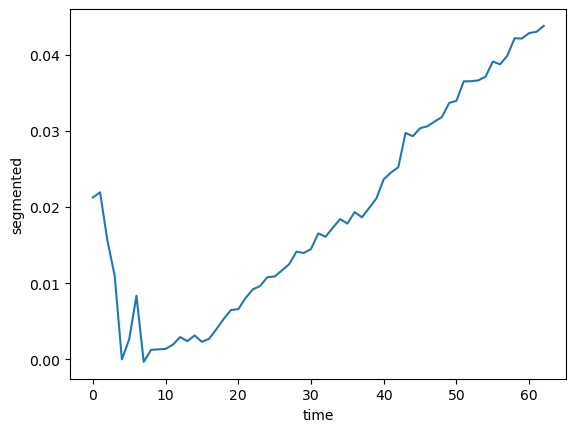

In [45]:
((CLareas[4]-CLareas)/CLareas[4]).plot()

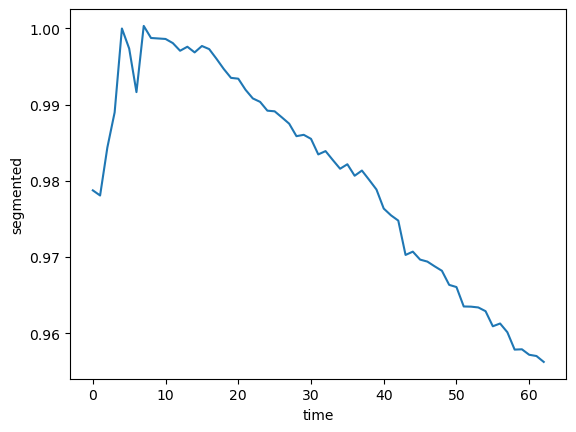

In [44]:
(CLareas/CLareas[4]).plot()

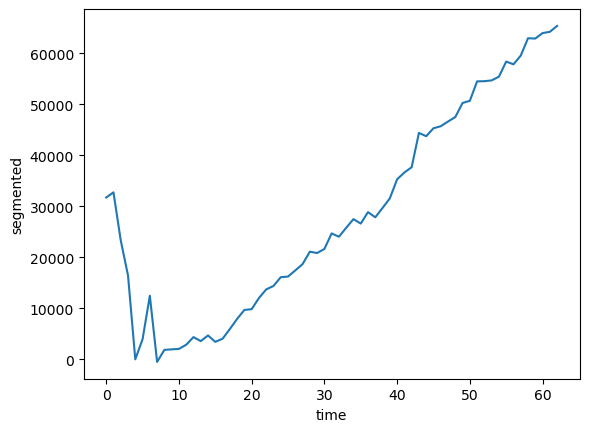

In [43]:
(CLareas[4]-CLareas).plot()

## Finding holes using initial image as seed

In [3]:
from skimage.morphology import disk, ball
from scipy import ndimage

In [4]:
im1 = seg_data['segmented'].sel(time = 2, x = 300).data

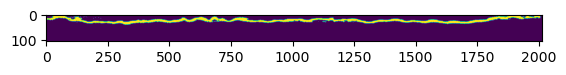

In [5]:
plt.imshow(im1)

In [6]:
im2 = seg_data['segmented'].sel(time = 40, x = 300).data

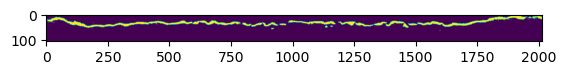

In [7]:
plt.imshow(im2)

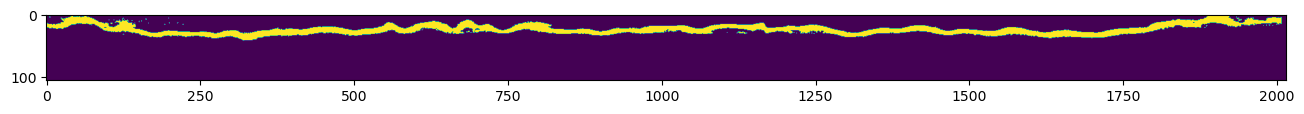

In [8]:
plt.figure(figsize=(16,9))
plt.imshow(im1)
mask = im2<1

In [121]:
def diffusion(mask, structure=disk(2), iterations = 300, face='top', free_pos = 0):
    init = np.zeros(mask.shape, dtype=bool)
    if face == 'top':
        init[:5,:] = True
    elif face == 'bottom':
        init[-5,:] = True
    elif face=='center':
        center_pos = int(init.shape[0]/2)
        init[center_pos,:] = True
    elif face == 'free':
        init[free_pos,:] = True
    else:
        print('face undefined, None returned')
        return None

    result = init.copy()*1
    reference = init.copy()*1
    flow = init.copy()
    flow2 = init.copy()
    for i in range(iterations):
        flow = ndimage.binary_dilation(flow, structure=structure, mask=mask)
        flow2 = ndimage.binary_dilation(flow2, structure=structure)
        result = result+flow*1
        reference = reference+flow2*1
        # flow = roughen_surface(flow, mask)
        
    return result, reference
        

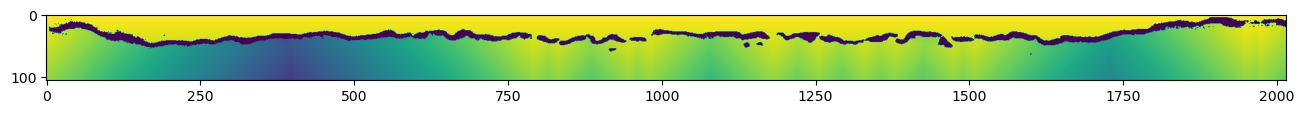

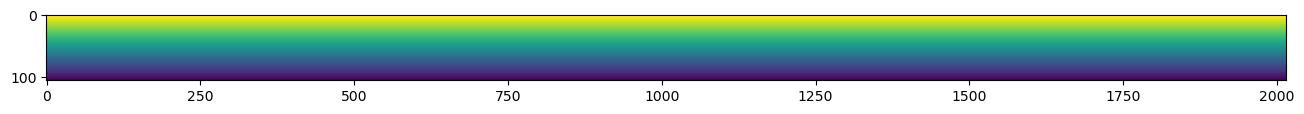

In [19]:
result_top, reference_top = diffusion(mask)
plt.figure(figsize=(16,9))
plt.imshow(result_top)
plt.figure(figsize=(16,9))
plt.imshow(reference_top)

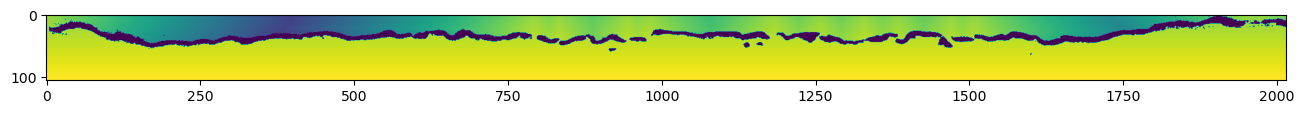

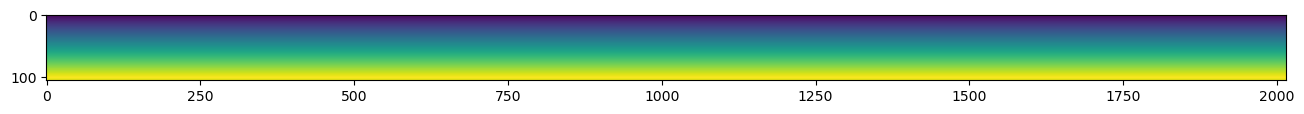

In [20]:
result_bot, reference_bot = diffusion(mask, face='bottom')
plt.figure(figsize=(16,9))
plt.imshow(result_bot)
plt.figure(figsize=(16,9))
plt.imshow(reference_bot)

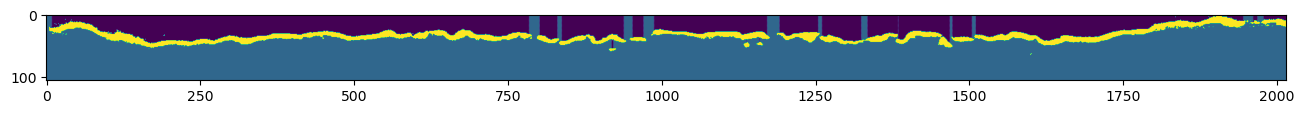

In [71]:
plt.figure(figsize=(16,9))
plt.imshow(1*((reference_bot-result_bot)<3)+im2*3)

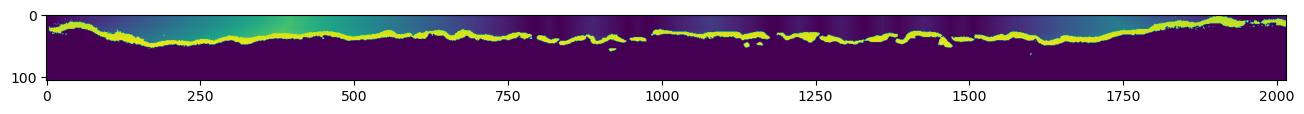

In [101]:
plt.figure(figsize=(16,9))
plt.imshow(reference_bot-result_bot)

In [72]:
# idea: remove the breakthroughs and you get a closed surface that you can compare to the CL

In [89]:
test1 = (reference_bot-result_bot)<1
test2 = (reference_top-result_top)<1 

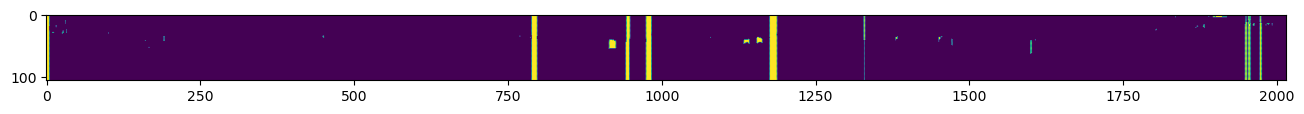

In [90]:
plt.figure(figsize=(16,9))
plt.imshow(test1^test2^mask)

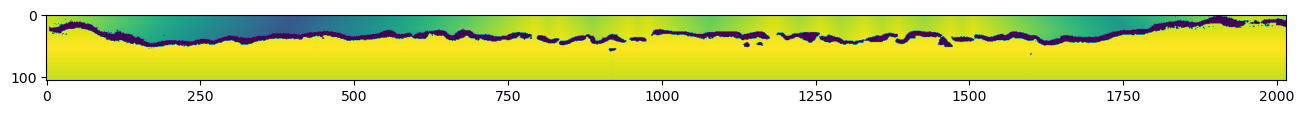

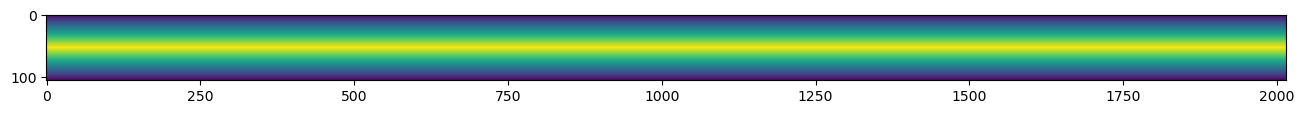

In [105]:
result_cent, reference_cent = diffusion(mask, face='center')
plt.figure(figsize=(16,9))
plt.imshow(result_cent)
plt.figure(figsize=(16,9))
plt.imshow(reference_cent)

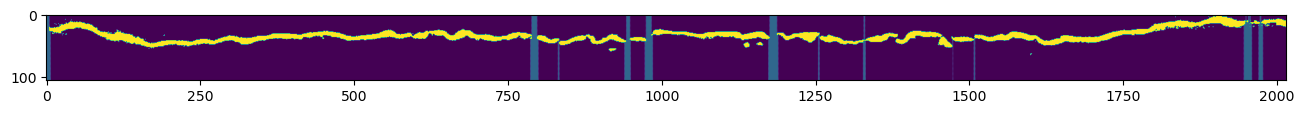

In [136]:
plt.figure(figsize=(16,9))
plt.imshow(1*(np.abs(result_top+result_bot+result_cent-reference_top-reference_bot-reference_cent)<1.1)+im2*3)

/tmp/ipykernel_2596966/3961933384.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(16,9))


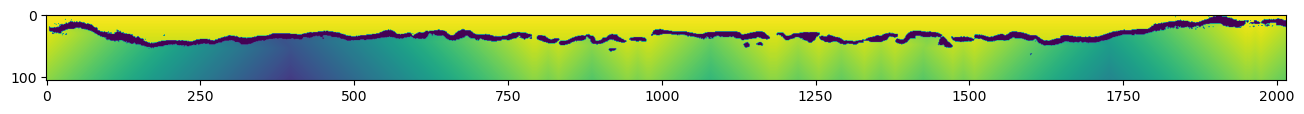

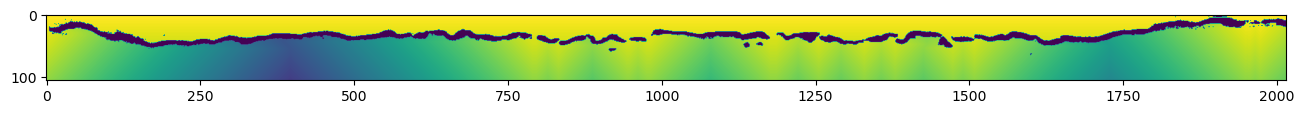

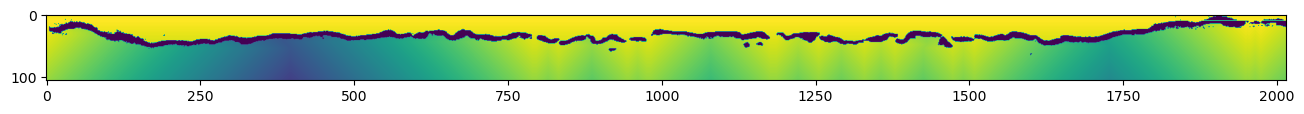

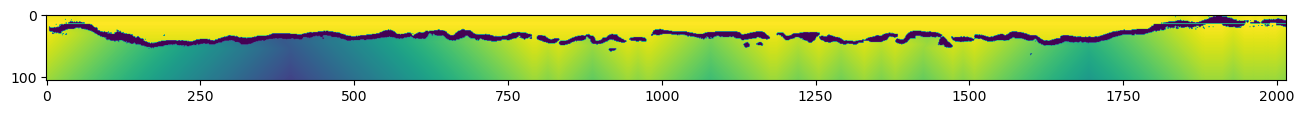

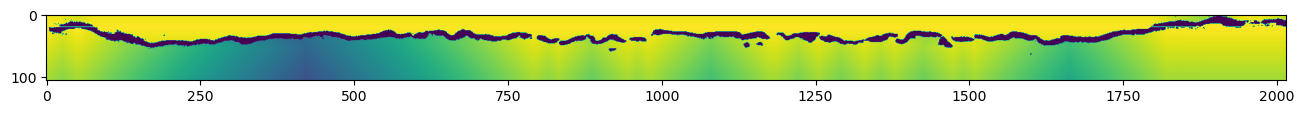

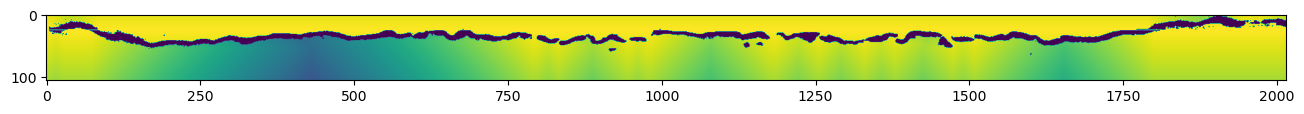

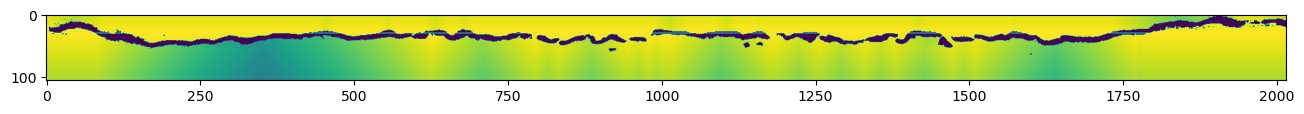

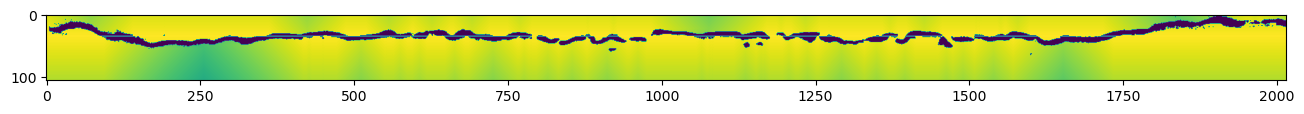

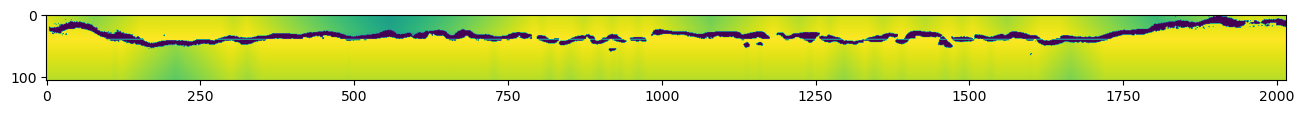

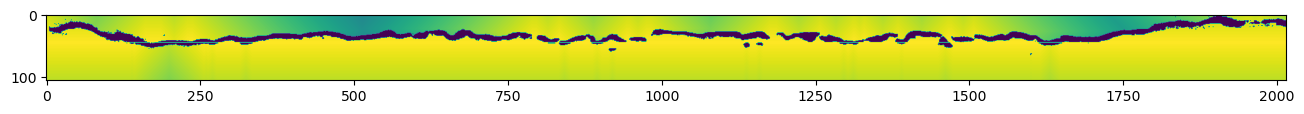

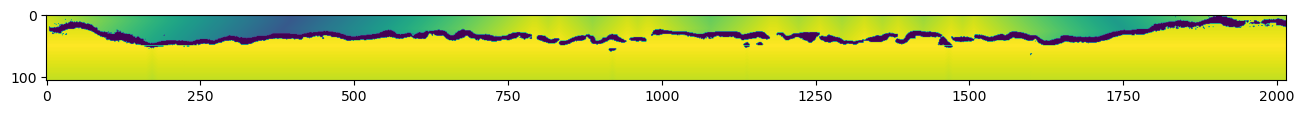

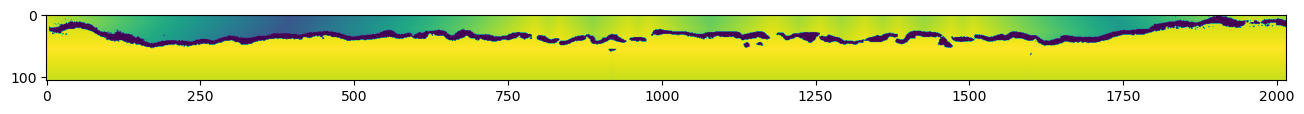

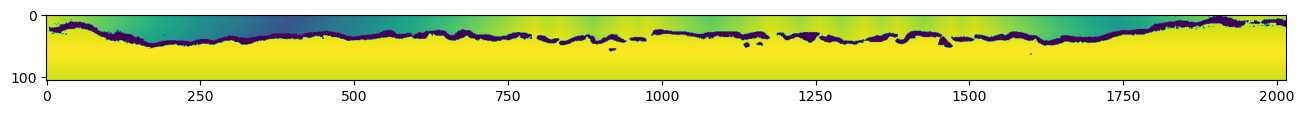

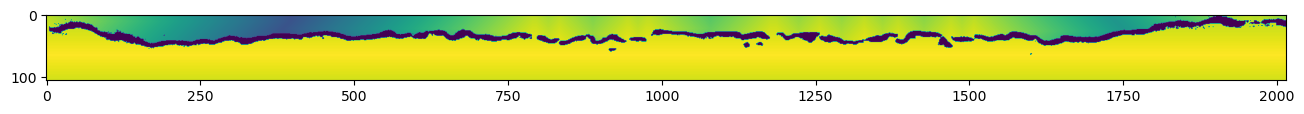

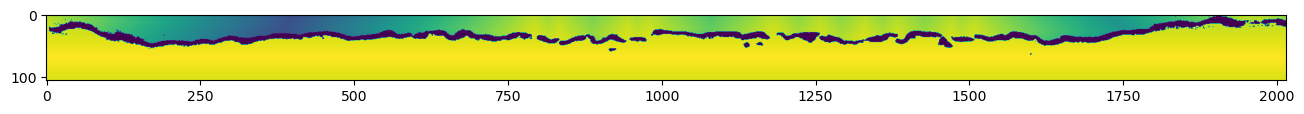

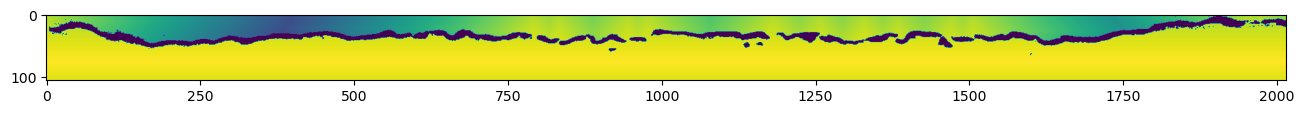

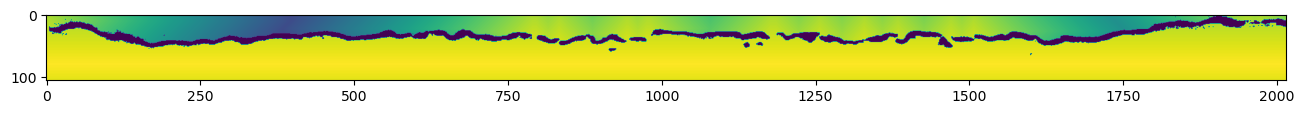

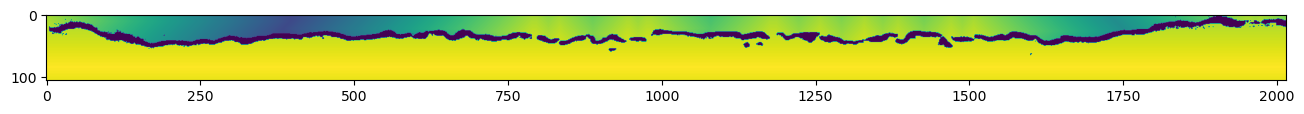

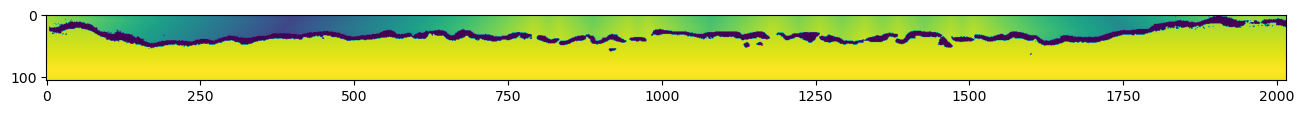

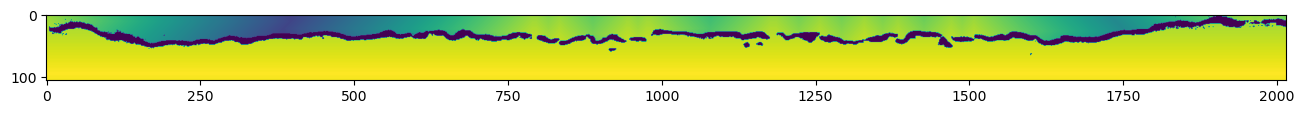

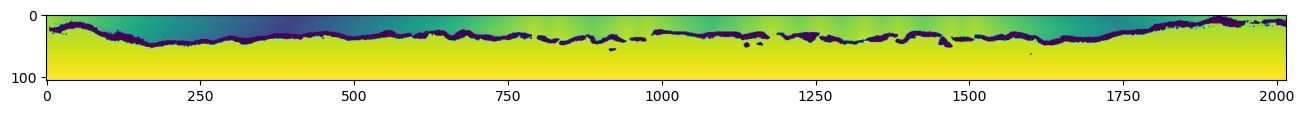

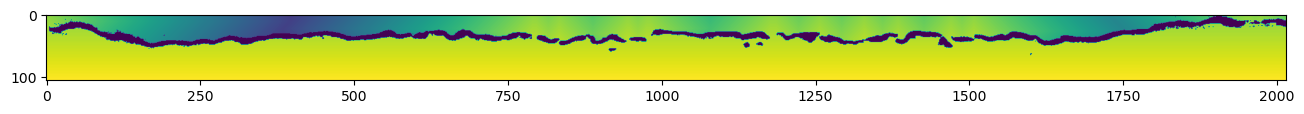

In [164]:
diffs = []
for i in range(0,mask.shape[0]+1,5):
    res,ref = diffusion(mask, face='free', free_pos=i, structure = disk(2))
    diffs.append(res-ref)
    plt.figure(figsize=(16,9))
    plt.imshow(res)
diffs = np.array(diffs)

/tmp/ipykernel_2596966/520165384.py:9: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(16,9))


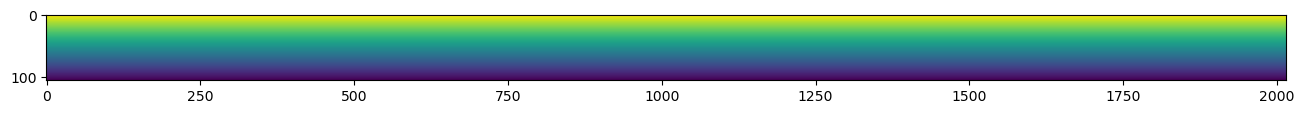

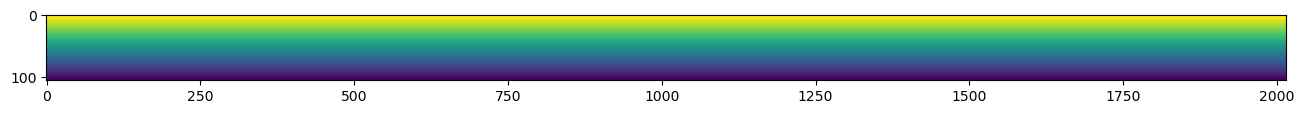

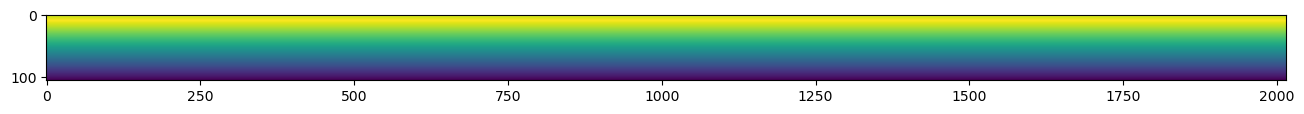

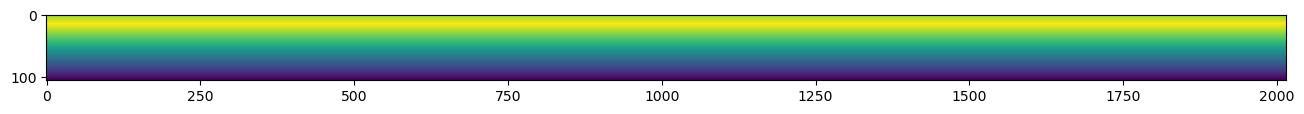

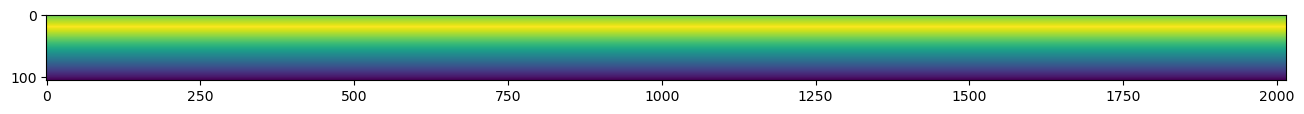

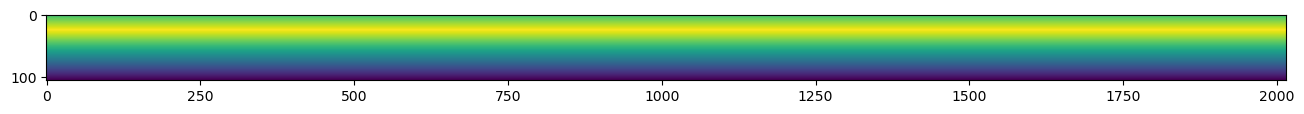

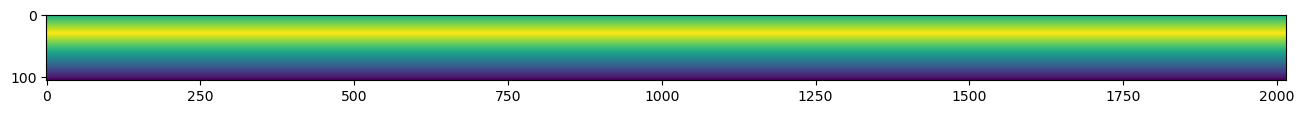

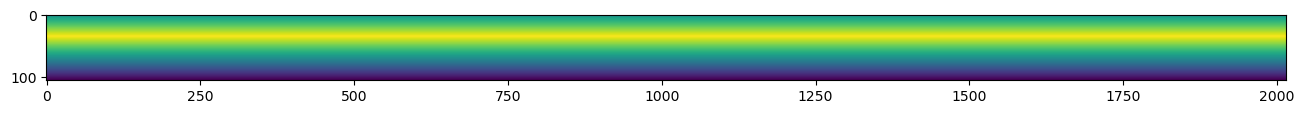

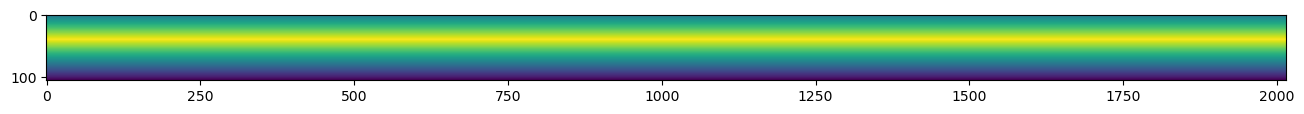

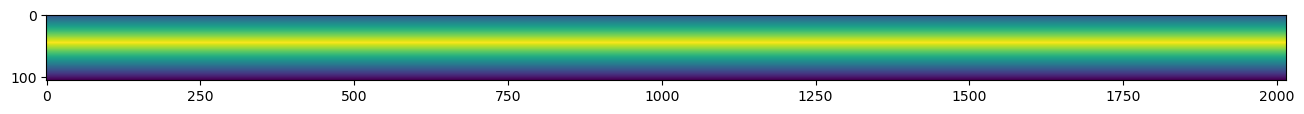

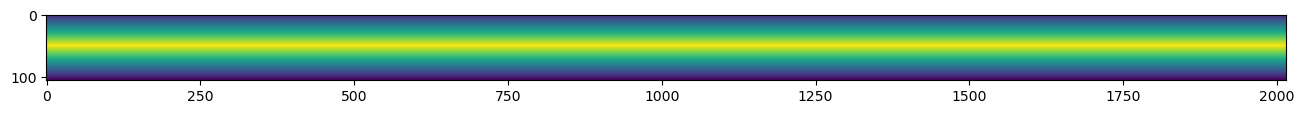

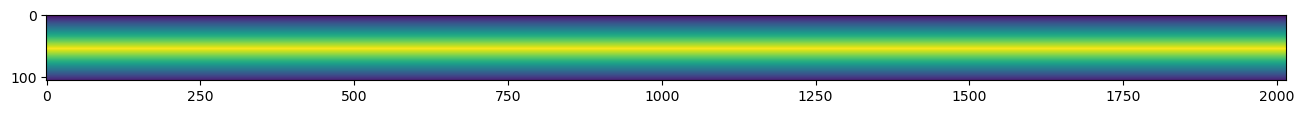

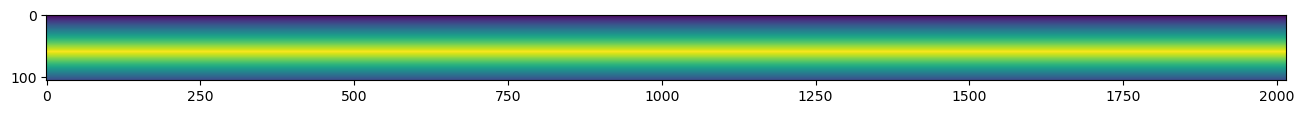

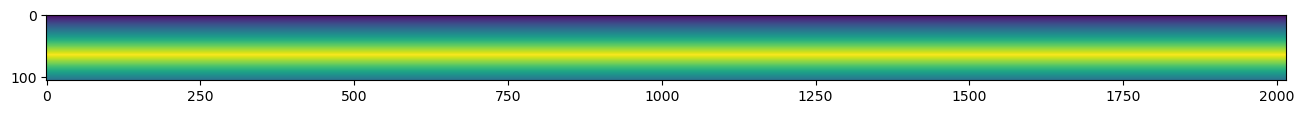

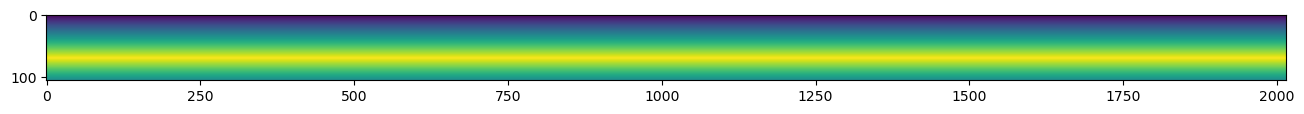

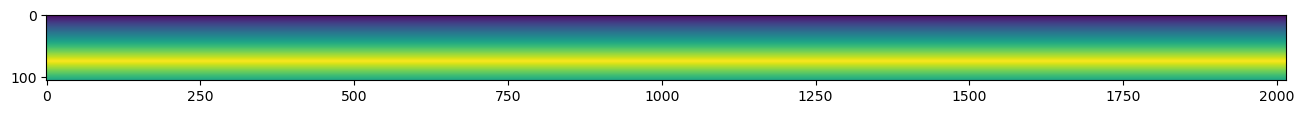

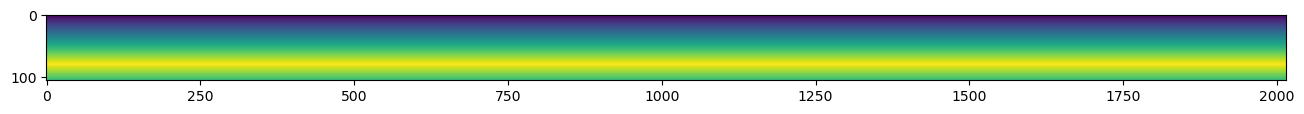

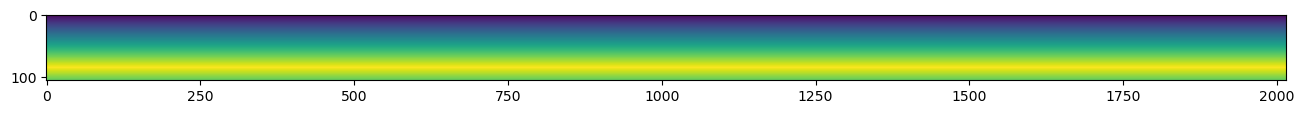

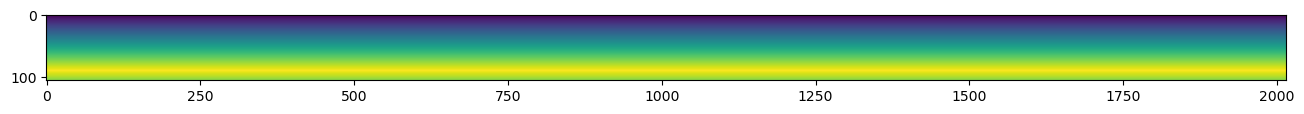

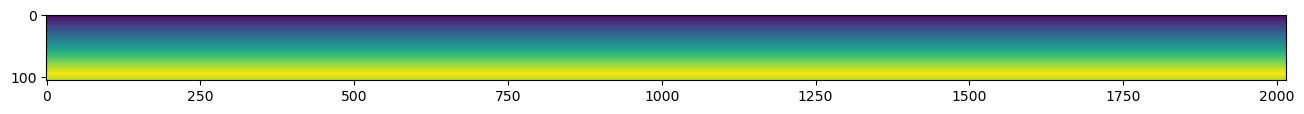

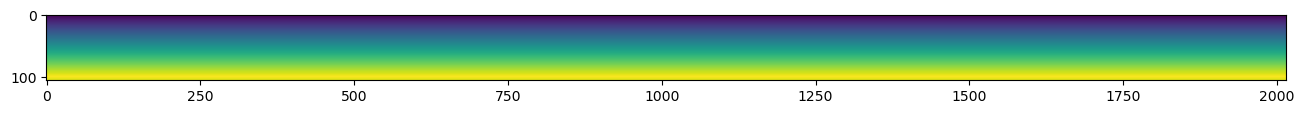

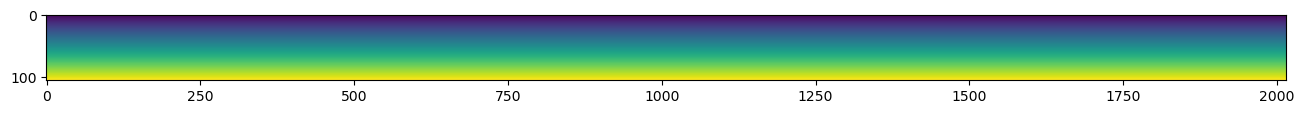

In [167]:
diffs = []
ress = []
refs = []
for i in range(0,mask.shape[0]+1,5):
    res,ref = diffusion(mask, face='free', free_pos=i, structure = disk(2))
    ress.append(res)
    refs.append(ref)
    diffs.append(res-ref)
    plt.figure(figsize=(16,9))
    plt.imshow(ref)
diffs = np.array(diffs)

In [161]:
comb1 = np.mean(diffs, axis=0)

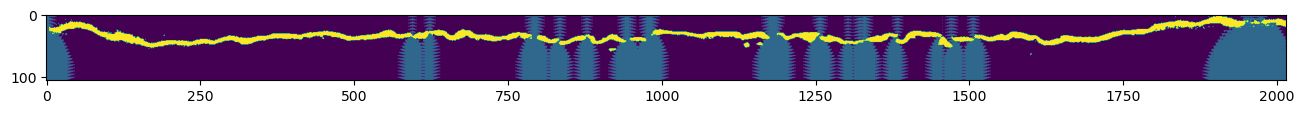

In [162]:
plt.figure(figsize=(16,9))
plt.imshow(1*(np.abs(comb)/22<0.5)+im2*3)

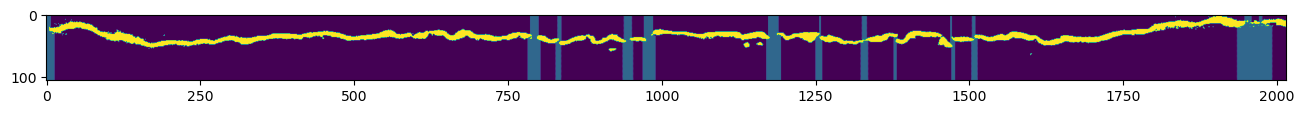

In [166]:
plt.figure(figsize=(16,9))
plt.imshow(1*(np.abs(comb1)<1.25)+im2*3)

In [197]:
ress_stack = np.stack(ress, axis=0).astype(np.uint16)
refs_stack = np.stack(refs,axis=0).astype(np.uint16)
diffs_stack = np.stack(diffs, axis=0)
diffs_stack = (diffs_stack-diffs_stack.min()).astype(np.uint16)

In [198]:
#save as tiff stack for visualization
refs_stack_with_CL = refs_stack.copy()
refs_stack_with_CL[:,~mask]=0

In [199]:
from skimage import io
import imageio

In [200]:
if not os.path.exists(os.path.join(toppath,'processing', '3II_CL_hole_scan')):
    os.mkdir(os.path.join(toppath,'processing', '3II_CL_hole_scan'))

io.imsave(os.path.join(toppath,'processing', '3II_CL_hole_scan', 'results.tif'), ress_stack)

/tmp/ipykernel_2596966/3396096688.py:4: UserWarning: /mpc/homes/fische_r/NAS/DASCOELY/processing/3II_CL_hole_scan/results.tif is a low contrast image
  io.imsave(os.path.join(toppath,'processing', '3II_CL_hole_scan', 'results.tif'), ress_stack)


In [201]:
io.imsave(os.path.join(toppath,'processing', '3II_CL_hole_scan', 'refrences.tif'), refs_stack)
io.imsave(os.path.join(toppath,'processing', '3II_CL_hole_scan', 'refrences_with_mask.tif'), refs_stack_with_CL)
io.imsave(os.path.join(toppath,'processing', '3II_CL_hole_scan', 'differences.tif'), diffs_stack)

/tmp/ipykernel_2596966/3946036774.py:1: UserWarning: /mpc/homes/fische_r/NAS/DASCOELY/processing/3II_CL_hole_scan/refrences.tif is a low contrast image
  io.imsave(os.path.join(toppath,'processing', '3II_CL_hole_scan', 'refrences.tif'), refs_stack)
/tmp/ipykernel_2596966/3946036774.py:2: UserWarning: /mpc/homes/fische_r/NAS/DASCOELY/processing/3II_CL_hole_scan/refrences_with_mask.tif is a low contrast image
  io.imsave(os.path.join(toppath,'processing', '3II_CL_hole_scan', 'refrences_with_mask.tif'), refs_stack_with_CL)
/tmp/ipykernel_2596966/3946036774.py:3: UserWarning: /mpc/homes/fische_r/NAS/DASCOELY/processing/3II_CL_hole_scan/differences.tif is a low contrast image
  io.imsave(os.path.join(toppath,'processing', '3II_CL_hole_scan', 'differences.tif'), diffs_stack)


In [191]:
ress_stack.dtype

dtype('int64')

## implement diffusive scanner in 3D using the GPU

In [2]:
import cupy as cp
# import cuci
from skimage.morphology import ball
from cucim.skimage.morphology import ball as GPUball
from scipy import ndimage
import cupyx.scipy.ndimage as GPUndimage
from joblib import Parallel, delayed
import time

In [3]:
# im2_3D = seg_data['segmented'].sel(time = 30).data

In [4]:
def hole_scan_3D(im3D, radius=2, iterations = 200, njobs=5):
    mask = im3D<1
    
    scan_pos = range(0, mask.shape[1]-1, 5)
    
    GPUS = [1, 2,3, 4]

    results = Parallel(n_jobs=njobs, temp_folder=temppath)(delayed(diffusion_3D)(mask, scan_pos[i], radius, iterations, GPUS[i%4]) for i in range(len(scan_pos)))
    diffs_stack = np.stack(results, axis=0)
    diff_mean = diffs_stack.mean(axis=0)
        
    return diff_mean
        

def diffusion_3D(mask, free_pos, radius, iterations = 200, gpu_id=0):
    
    # wait for free GPU RAM
    while cp.cuda.Device(gpu_id).mem_info[0]<8E9:
        time.sleep(1)
    
    
    with cp.cuda.Device(gpu_id):
        structure = GPUball(radius)
        mask = cp.array(mask)
        init = cp.zeros(mask.shape, dtype=bool)
        init[:,free_pos,:] = True

        result = init.copy()*1
        reference = init.copy()*1
        flow = init.copy()
        flow2 = init.copy()

        for i in range(iterations):
            flow = GPUndimage.binary_dilation(flow, structure, mask=mask)
            flow2 = GPUndimage.binary_dilation(flow2, structure)
            result = result+flow*1
            reference = reference+flow2*1

        difference = result-reference
        difference = cp.asnumpy(difference)
    
        del result, reference, flow, flow2, init
    
        mempool = cp.get_default_memory_pool()
        mempool.free_all_blocks()
    return difference
    

In [6]:
cp.cuda.Device(0).mem_info

(2809593856, 47674818560)

In [6]:
diff_mean = hole_scan_3D(im2_3D)

NameError: name 'im2_3D' is not defined

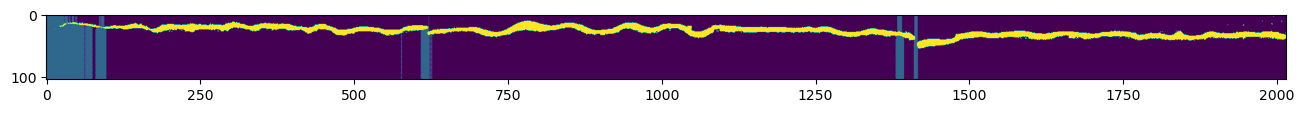

In [20]:
plt.figure(figsize=(16,9))
x = 495
plt.imshow((diff_mean[x,:,:,]>-0.5)*1+im2_3D[x,:,:,]*3)

In [43]:
oldarea = seg_data['segmented'].sel(time=30).sum(dim='y')>0
oldarea0 = seg_data['segmented'].sel(time=4).sum(dim='y')>0

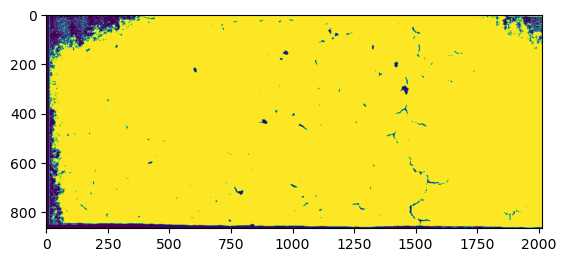

In [22]:
plt.imshow(oldarea)

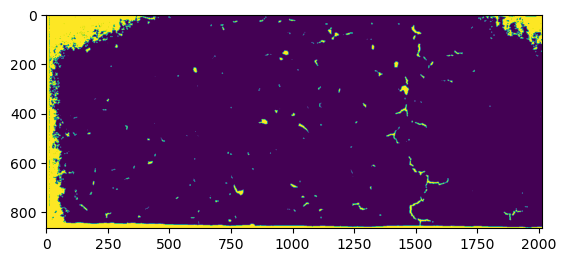

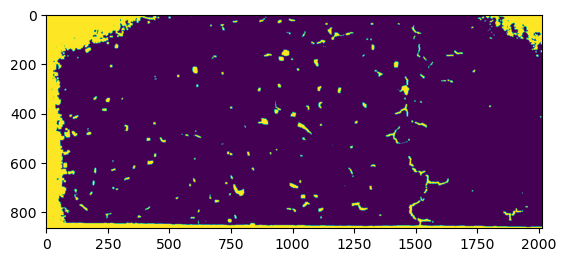

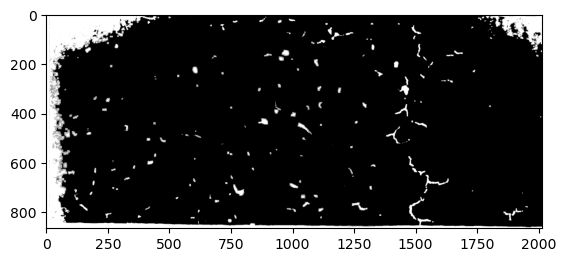

In [49]:
holes1 = diff_mean[:,0,:]>-0.5
holes2 = diff_mean[:,-1,:]>-0.5

plt.imshow(holes1)
plt.figure()
plt.imshow(holes2)
plt.figure()
plt.imshow(holes1*1+holes2*2, 'gray')

In [35]:
((diff_mean[:,0,:]<-0.5).sum()+(diff_mean[:,-1,:]<-0.5).sum())/2

1604628.5

## apply to all samples and timesteps

In [7]:
samples = ['1', '4', '5', '6', '3II', '5II','4II', '8x', '3III', '7x']
samples = ['5II']

for sample in samples:
    print(sample)
    # if sample in samples[:5]:
    #     print(sample,'already done')
    #     continue
    segpath = os.path.join(toppath, 'processing','06_anode_CL', ''.join(['06_'+sample,'_anode_CL_segmented_filtered.nc']))

    seg_data = xr.open_dataset(segpath)
    
    shp = seg_data['segmented'].shape
    
    length = len(seg_data['time'])
    CLholes = np.zeros(length)
    CLhole_area = np.zeros((shp[0],shp[2],length))
    for i in range(length):
        if i%10 == 0: print(str(i)+'/'+str(length))
        t = seg_data['time'][i]
        im2_3D = seg_data['segmented'].sel(time = t).data
        diff_mean = hole_scan_3D(im2_3D)
        
        holes1 = diff_mean[:,0,:]>-0.5
        holes2 = diff_mean[:,-1,:]>-0.5
        
        CLhole_area[:,:,i] = holes1*1+holes2*2
        CLholes[i] = holes1.sum()/2+holes2.sum()/2
    
    seg_data.close()
    data = xr.Dataset({'CL_damaged_area': ('time', CLholes),
                      'CL_holes_segmented': (['x','y','time'], CLhole_area)},
                      coords = {'time': np.arange(length),
                                'x': np.arange(CLhole_area.shape[0]),
                                'y': np.arange(CLhole_area.shape[1])},
                      attrs = {'comment': 'CL_holes_segmented: 1 are holes on top, 2 on bottom, 3 for both'} 
                     )
    outpath = os.path.join(toppath, 'processing','06_anode_CL',sample+'_CLarea_holes_with_area_'+git_sha+'.nc')
    data.to_netcdf(outpath)
    
    
        

5II
0/58


/mpc/homes/fische_r/miniconda3/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


10/58
20/58
30/58
40/58
50/58


In [8]:
seg_data.close()

In [9]:
data = xr.Dataset({'CL_damaged_area_count': ('time', CLholes),
                  'CL_damaged_area': (['x','z','time'], CLhole_area)},
                  coords = {'time': np.arange(length),
                           'x': np.arange(shp[0]),
                           'z': np.arange(shp[2])}
                 )
outpath = os.path.join(toppath, 'processing','06_anode_CL',sample+'_CLarea_holes_with_area_'+git_sha+'.nc')
data.to_netcdf(outpath)

In [20]:
data

<xarray.Dataset>
Dimensions:             (time: 88, x: 860, y: 2016)
Coordinates:
  * time                (time) int64 0 1 2 3 4 5 6 7 ... 80 81 82 83 84 85 86 87
  * x                   (x) int64 0 1 2 3 4 5 6 ... 853 854 855 856 857 858 859
  * y                   (y) int64 0 1 2 3 4 5 ... 2010 2011 2012 2013 2014 2015
Data variables:
    CL_damaged_area     (time) float64 4.538e+05 4.54e+05 ... 7.26e+05 7.521e+05
    CL_holes_segmented  (x, y, time) float64 3.0 3.0 3.0 3.0 ... 3.0 3.0 3.0 3.0
Attributes:
    comment:  CL_holes_segmented: 1 are holes on top, 2 on bottom, 3 for both